For Matt's paper revisions, they want to emphasize that K27ac peaks in p300-dCas9 cells and K9me3 in KRAB-dCas9 cells are inducing changes in gene expression. 

To prove this hypothesis, Charlie and Matt want to show that there is an enrichment 

In [1]:
import seaborn as sns
import os
import scipy.stats as stats
from matplotlib import pyplot as plt
sns.set_context('talk')
sns.set_style('ticks')
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['lines.markersize'] = 20
import pandas as pd


In [6]:
degs = pd.read_csv('/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/mm10Liver.rnaseq.PDX1_vs_mm10Liver.rnaseq.PBS.unshrunk.with_genes.txt', sep='\t')


In [10]:
genes = pd.read_csv('/data/reddylab/Reference_Data/Gencode/vM19/gencode.vM19.basic.annotation.bed', 
                    sep='\t', names = ['chrom', 'start', 'end', 'ensembl_id', 'score', 'strand', 'gene_symbol', 'gene_type'])

In [27]:
tmp = degs.merge(genes.loc[:, ['ensembl_id', 'chrom','start', 'end', 'strand']], left_on='Unnamed: 0', right_on='ensembl_id', how='inner')
tmp.index = tmp.ensembl_id
tmp.drop(['Unnamed: 0', 'ensembl_id'], axis=1, inplace=True)
tmp['tss_start'] = tmp.apply(lambda x: x['start'] if x['strand'] == '+' else x['end'], axis = 1)
tmp['tss_end'] = tmp['tss_start'] + 1
tmp.to_csv('/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/mm10Liver.rnaseq.PDX1_vs_mm10Liver.rnaseq.PBS.unshrunk.with_genes.with_coords.txt', sep='\t')

In [7]:
peaks  = pd.read_csv('/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/differential_testing/deseq2/mmLiver_p300.K27ac.targeted_vs_mmLiver_p300.K27ac.PBS.unshrunk.with_closest_gene.txt', sep='\t')


In [48]:
%%bash
mkdir -p /data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/proximity_analysis/shuffled
RNASEQ_DEGS='/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/mm10Liver.rnaseq.PDX1_vs_mm10Liver.rnaseq.PBS.unshrunk.with_genes.with_coords.txt'
CHIPSEQ_DAS='/data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/differential_testing/deseq2/mmLiver_p300.K27ac.targeted_vs_mmLiver_p300.K27ac.PBS.unshrunk.with_closest_gene.txt'
FDR_THRES='0.05'
N_DA_PEAKS=$(tail -n+2 ${CHIPSEQ_DAS} | awk -vFDR_THRES=${FDR_THRES} -vOFS='\t' '$7<=FDR_THRES{print $1}' | wc -l)
bedtools closest \
    -d \
    -a <(tail -n+2 ${RNASEQ_DEGS} | awk -vFDR_THRES=${FDR_THRES} -vOFS='\t' '$7<=FDR_THRES{print $(NF-5), $(NF-1), $NF}' | sort -k1,1 -k2,2n) \
    -b <(tail -n+2 ${CHIPSEQ_DAS} | awk -vFDR_THRES=${FDR_THRES} -vOFS='\t' '$7<=FDR_THRES{print $1}' | sed 's@_@\t@g'| sort -k1,1 -k2,2n) \
| sort -k7,7g | awk '$(NF)!=-1'  \
> /data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/proximity_analysis/degs.PDX1_vs_PBS.closest.K27ac_DA.txt

bedtools closest \
    -d \
    -a <(tail -n+2 ${RNASEQ_DEGS} | awk -vFDR_THRES=${FDR_THRES} -vOFS='\t' '$7<=FDR_THRES{print $(NF-5), $(NF-1), $NF}' | sort -k1,1 -k2,2n) \
    -b <(tail -n+2 ${CHIPSEQ_DAS} | awk -vFDR_THRES=${FDR_THRES} -vOFS='\t' '$7>FDR_THRES{print $1}' | sed 's@_@\t@g' | sort -k1,1 -k2,2n) \
| sort -k7,7g | awk '$(NF)!=-1' \
> /data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/proximity_analysis/degs.PDX1_vs_PBS.closest.K27ac_nonDA.txt

# for ii in $(seq 1 100);
# do
#     bedtools closest \
#         -d \
#         -a <(tail -n+2 ${RNASEQ_DEGS} | awk -vFDR_THRES=${FDR_THRES} -vOFS='\t' '$7<=FDR_THRES{print $(NF-5), $(NF-1), $NF}' | sort -k1,1 -k2,2n) \
#         -b <(tail -n+2 ${CHIPSEQ_DAS} | awk -vFDR_THRES=${FDR_THRES} -vOFS='\t' '$7>FDR_THRES{print $1}' | sed 's@_@\t@g' | shuf -n ${N_DA_PEAKS} | sort -k1,1 -k2,2n) \
#     | sort -k7,7g | awk '$(NF)!=-1' \
#     > /data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/proximity_analysis/shuffled/degs.PDX1_vs_PBS.closest.K27ac_nonDA.shuf_$(printf "%04d" ${ii}).txt

# done

In [2]:
n_nonsig_all = !tail -n+2 /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/differential_testing/deseq2/mmLiver_p300.K27ac.targeted_vs_mmLiver_p300.K27ac.PBS.unshrunk.with_closest_gene.txt | awk -vFDR_THRES=0.05 -vOFS='\t' '$7>FDR_THRES{print $1}' | wc -l
n_nonsig_all = int(n_nonsig_all[0])

In [3]:
n_sig = !tail -n+2 /data/reddylab/Alex/collab/20190701_Matt/results/chip_seq/differential_testing/deseq2/mmLiver_p300.K27ac.targeted_vs_mmLiver_p300.K27ac.PBS.unshrunk.with_closest_gene.txt | awk -vFDR_THRES=0.05 -vOFS='\t' '$7<=FDR_THRES{print $1}' | wc -l
n_sig = int(n_sig[0])

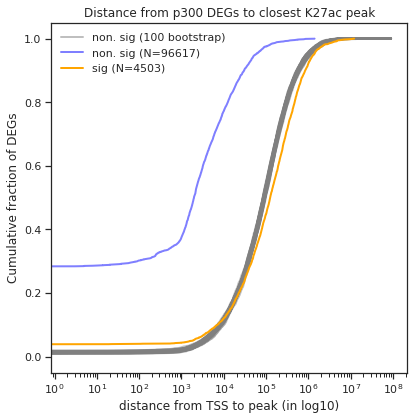

In [74]:
sns.set_context('notebook')
import numpy as np
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=[6, 6])
shuffled_datadir = "/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/proximity_analysis/shuffled/"
for ix, ii in enumerate([c for c in os.listdir(shuffled_datadir) if 'degs.PDX1_vs_PBS.closest.K27ac_nonDA' in c ]):
    nonsig_df = pd.read_csv("%s/%s" % (shuffled_datadir, ii),
                         sep='\t', header=None, usecols=[6])

    plt.plot(
        nonsig_df.sort_values(by=6),
        1.*np.array(range(nonsig_df.shape[0]))/nonsig_df.shape[0], 
        color='grey', linewidth=2, alpha=.5,
        label='non. sig (100 bootstrap)' if ix==0 else ''
    )

nonsig_df = pd.read_csv('/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/proximity_analysis/degs.PDX1_vs_PBS.closest.K27ac_nonDA.txt',
                     sep='\t', header=None,usecols=[6])
plt.plot(
    nonsig_df.sort_values(by=6),
    1.*np.array(range(nonsig_df.shape[0]))/nonsig_df.shape[0], 
    color='blue', linewidth=2, alpha=.5,
    label='non. sig (N=%d)' % n_nonsig_all
)
    
sig_df = pd.read_csv('/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/proximity_analysis/degs.PDX1_vs_PBS.closest.K27ac_DA.txt',
                     sep='\t', header=None,usecols=[6])
plt.plot(
    sig_df.sort_values(by=6),
    1.*np.array(range(sig_df.shape[0]))/sig_df.shape[0], 
    label='sig (N=%d)' % n_sig, linewidth=2, color='orange'
#     marker='o'
)
plt.xscale('log',basex=10)
plt.legend(frameon=False)
plt.title('Distance from p300 DEGs to closest K27ac peak');
plt.xlabel('distance from TSS to peak (in log10)')
plt.ylabel('Cumulative fraction of DEGs')
plt.tight_layout()
plt.savefig('/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/proximity_analysis/degs.PDX1_vs_PBS.closest.K27ac_DA.pdf')


So, that didn't seem to show what we 

In [21]:
degs.head(25)

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000068742.11,703.867415,0.686001,0.109955,6.238918,4.406077e-10,0.000006,Cry2,protein_coding
1,ENSMUSG00000029644.7,28.197758,7.789290,1.290461,6.036050,1.579325e-09,0.000010,Pdx1,protein_coding
2,ENSMUSG00000002227.15,701.876817,-0.477094,0.089251,-5.345528,9.015410e-08,0.000384,Mov10,protein_coding
3,ENSMUSG00000081223.1,70.514393,2.672135,0.517988,5.158680,2.486963e-07,0.000636,Gm12247,processed_pseudogene
4,ENSMUSG00000105703.1,1154.865099,-4.685246,0.905339,-5.175127,2.277559e-07,0.000636,Gm43305,TEC
5,ENSMUSG00000079017.3,174.433347,-1.289426,0.252152,-5.113680,3.159425e-07,0.000673,Ifi27l2a,protein_coding
6,ENSMUSG00000052435.6,78.923657,-7.663483,1.535772,-4.989987,6.038330e-07,0.001103,Cebpe,protein_coding
7,ENSMUSG00000035208.16,63.349776,-1.059521,0.233946,-4.528919,5.928615e-06,0.009473,Slfn8,protein_coding
8,ENSMUSG00000087107.8,37.396237,-1.515825,0.340994,-4.445308,8.776600e-06,0.011219,AI662270,processed_transcript
9,ENSMUSG00000075268.2,26.204637,3.373462,0.757819,4.451540,8.525680e-06,0.011219,Gm10819,processed_pseudogene


In [4]:
expanded_df = pd.DataFrame()
for ii in peaks[peaks.genes.str.contains(',')].iterrows():
    for g in ii[1]['genes'].split(','):
        tmp = ii[1]
        tmp['genes'] = g
        expanded_df = expanded_df.append(tmp)

In [48]:
peaks.columnsns

Index([u'Unnamed: 0', u'baseMean', u'log2FoldChange', u'lfcSE', u'stat',
       u'pvalue', u'padj', u'genes', u'distance'],
      dtype='object')

In [50]:
expanded_merged = pd.concat([expanded_df.loc[:, peaks.columns], 
          peaks[~peaks.genes.str.contains(',')]])

In [58]:
degs.loc[degs.padj<0.05, ['GeneName', 'log2FoldChange', 'padj']].head()

,GeneName,log2FoldChange,padj
0,Cry2,0.686001,0.000006
1,Pdx1,7.789290,0.000010
2,Mov10,-0.477094,0.000384
3,Gm12247,2.672135,0.000636
4,Gm43305,-4.685246,0.000636


In [54]:
expanded_merged.head()

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,distance
5,chr5_147268985_147270986,21.637383,1.871428,0.449938,4.159305,0.000032,0.358853,Pdx1,0.0
5,chr5_147268985_147270986,21.637383,1.871428,0.449938,4.159305,0.000032,0.358853,Plut,0.0
7,chr18_43477532_43477801,9.559277,-3.013968,0.719371,-4.189725,0.000028,0.358853,Gm27325,0.0
7,chr18_43477532_43477801,9.559277,-3.013968,0.719371,-4.189725,0.000028,0.358853,Eif3j2,0.0
14,chr14_50955724_50957254,49.815002,-1.354051,0.344779,-3.927298,0.000086,0.542896,Pnp2,0.0


In [56]:
expanded_merged.loc[expanded_merged.padj<0.05, ['genes', 'log2FoldChange', 'padj']]\
    .merge(degs.loc[degs.padj<0.05, ['GeneName', 'log2FoldChange', 'padj']], 
           left_on='genes', right_on='GeneName', suffixes=['_peak', '_deg'])

,genes,log2FoldChange_peak,padj_peak,GeneName,log2FoldChange_deg,padj_deg


In [51]:
sig_merged=expanded_merged.loc[expanded_merged.padj<0.05, ['genes', 'log2FoldChange', 'padj']]\
    .merge(degs.loc[degs.padj<0.05, ['GeneName', 'log2FoldChange', 'padj']], 
           left_on='genes', right_on='GeneName', suffixes=['_peak', '_deg'],
          how='inner')

In [52]:
sig_merged

,genes,log2FoldChange_peak,padj_peak,GeneName,log2FoldChange_deg,padj_deg


ValueError: Axis limits cannot be NaN or Inf

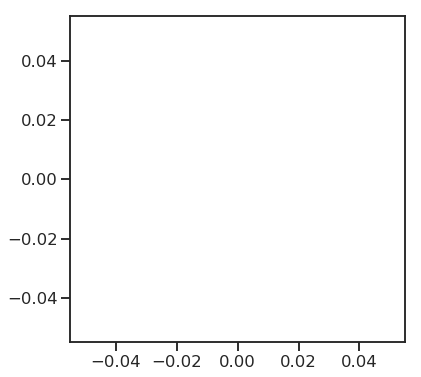

In [53]:
fig, ax = plt.subplots(figsize=[6, 6 ])
sns.scatterplot(x='log2FoldChange_deg', y='log2FoldChange_peak', 
                data=sig_merged,
               s=30)
plt.vlines(0, sig_merged['log2FoldChange_peak'].min()*1.1, sig_merged['log2FoldChange_peak'].max()*1.1, 
           linestyle='-', color='black')
plt.hlines(0, sig_merged['log2FoldChange_deg'].min()*1.1, sig_merged['log2FoldChange_deg'].max()*1.1, 
           linestyle='-', color='black')
plt.plot(
    [sig_merged['log2FoldChange_deg'].min()*1.1, sig_merged['log2FoldChange_deg'].max()*1.1],
    [sig_merged['log2FoldChange_deg'].min()*1.1, sig_merged['log2FoldChange_deg'].max()*1.1],
    'g--'
)
plt.ylim(sig_merged['log2FoldChange_peak'].min()*1.1, sig_merged['log2FoldChange_peak'].max()*1.1);
plt.xlim(sig_merged['log2FoldChange_deg'].min()*1.1, sig_merged['log2FoldChange_deg'].max()*1.1);
# sns.despine()

In [45]:
sig_merged

,genes,log2FoldChange_peak,padj_peak,GeneName,log2FoldChange_deg,padj_deg
0,Mov10,0.784173,0.008869,Mov10,-0.477094,0.000384
1,Pdx1,1.373357,0.046383,Pdx1,7.789290,0.000010
2,Gm43305,-3.279800,0.000476,Gm43305,-4.685246,0.000636
3,Gm43305,-2.877454,0.005905,Gm43305,-4.685246,0.000636
4,Gm43305,-1.826731,0.023282,Gm43305,-4.685246,0.000636
5,Ifi27l2a,0.799791,0.025439,Ifi27l2a,-1.289426,0.000673


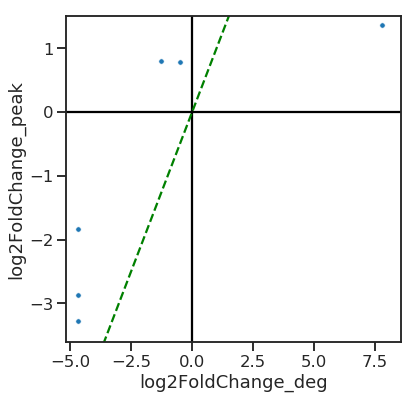

In [47]:
fig, ax = plt.subplots(figsize=[6, 6 ])
sns.scatterplot(x='log2FoldChange_deg', y='log2FoldChange_peak', 
                data=sig_merged,
               s=30)
plt.vlines(0, sig_merged['log2FoldChange_peak'].min()*1.1, sig_merged['log2FoldChange_peak'].max()*1.1, 
           linestyle='-', color='black')
plt.hlines(0, sig_merged['log2FoldChange_deg'].min()*1.1, sig_merged['log2FoldChange_deg'].max()*1.1, 
           linestyle='-', color='black')
plt.plot(
    [sig_merged['log2FoldChange_deg'].min()*1.1, sig_merged['log2FoldChange_deg'].max()*1.1],
    [sig_merged['log2FoldChange_deg'].min()*1.1, sig_merged['log2FoldChange_deg'].max()*1.1],
    'g--'
)
plt.ylim(sig_merged['log2FoldChange_peak'].min()*1.1, sig_merged['log2FoldChange_peak'].max()*1.1);
plt.xlim(sig_merged['log2FoldChange_deg'].min()*1.1, sig_merged['log2FoldChange_deg'].max()*1.1);
# sns.despine()

In [10]:
expanded_merged.loc[expanded_merged.padj<0.05, ['genes', 'log2FoldChange', 'padj']]\
    .merge(degs.loc[degs.padj<0.05, ['GeneName', 'log2FoldChange', 'padj']], 
           left_on='genes', right_on='GeneName', suffixes=['_peak', '_deg'],
          how='inner').head()

,genes,log2FoldChange_peak,padj_peak,GeneName,log2FoldChange_deg,padj_deg
0,Mov10,0.784173,0.008869,Mov10,-0.477094,0.000384
1,Pdx1,1.373357,0.046383,Pdx1,7.789290,0.000010
2,Gm43305,-3.279800,0.000476,Gm43305,-4.685246,0.000636
3,Gm43305,-2.877454,0.005905,Gm43305,-4.685246,0.000636
4,Gm43305,-1.826731,0.023282,Gm43305,-4.685246,0.000636


In [46]:
expanded_df.head()

,Unnamed: 0,baseMean,distance,genes,lfcSE,log2FoldChange,padj,pvalue,stat
13,chr6_28704715_28707849,130.906446,0.0,Lrrc4,0.190932,1.644139,5.258592e-14,7.233557e-18,8.611143
13,chr6_28704715_28707849,130.906446,0.0,Snd1,0.190932,1.644139,5.258592e-14,7.233557e-18,8.611143
24,chr14_54120367_54123079,104.100621,0.0,Trdd2,0.258897,2.075059,4.455100e-12,1.101493e-15,8.014986
24,chr14_54120367_54123079,104.100621,0.0,Gm30275,0.258897,2.075059,4.455100e-12,1.101493e-15,8.014986
36,chr19_6540914_6550085,373.043446,0.0,Gm14967,0.234241,1.784248,6.980033e-11,2.593134e-14,7.617162


In [ ]:
def expland_df(df):
    

In [23]:
peaks[peaks.padj<0.05].head(20)

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,distance
0,chr15_59337389_59340026,117.674189,2.642172,0.241847,10.924980,8.755987e-28,8.853616e-23,Washc5,0
1,chr2_93878785_93883159,168.251922,2.676344,0.258344,10.359625,3.784413e-25,1.310993e-20,Accsl,-9629
2,chr15_62568539_62572394,153.136396,2.973205,0.287072,10.357002,3.889610e-25,1.310993e-20,Gm41333,0
3,chr9_45688769_45691600,111.961588,2.847379,0.294728,9.661055,4.412958e-22,1.115541e-17,Dscaml1,0
4,chr16_95813339_95816475,178.147533,2.153721,0.228721,9.416357,4.670104e-21,9.444352e-17,CT030665.2,0
5,chr9_23444230_23446193,134.030932,1.955340,0.212899,9.184339,4.140629e-20,6.977995e-16,Bmper,0
6,chr11_74521486_74525129,228.232685,1.989433,0.218842,9.090717,9.838829e-20,1.421219e-15,Rap1gap2,0
7,chrX_7738444_7741837,124.825925,2.039095,0.225518,9.041839,1.540581e-19,1.947198e-15,Ccdc120,0
8,chr14_67831881_67834697,103.746042,2.458500,0.275657,8.918687,4.718480e-19,5.301212e-15,Dock5,0
9,chr1_9635998_9641096,252.656204,1.536612,0.174537,8.803926,1.321120e-18,1.335851e-14,Gm29520,0


In [ ]:
# %load /data/reddylab/projects/reddylab_utils/scripts/plot_cdf_distance_queries_to_target_bed.py
#!/usr/bin/env python
import numpy as np
from pybedtools import BedTool
import pybedtools
from scipy.stats import mannwhitneyu
from statsmodels.distributions.empirical_distribution import ECDF
from reddylab_utils.reddylab_plotting_utils import discrete_cmap

import matplotlib
matplotlib.use('Agg')
font = {'size' : 8}
matplotlib.rc('font', **font)
import matplotlib.pyplot as plt

from matplotlib.patches import Polygon
import matplotlib.patches as mpatches
import palettable.colorbrewer.sequential

import argparse
parser = argparse.ArgumentParser(formatter_class=argparse.RawTextHelpFormatter, \
description="""

plot_cdf_distance_queries_to_target_bed.py

This script plots the cumulative distribution function (CDF) of the distances
of all sites in each of a list of query bed files to a target bed file.

""")

##################################################
# required args:

parser.add_argument("--queries", nargs='+', type=str,
                    help="""required, file paths to beds of query sites of interest, e.g.:
/path/to/site_group1.bed /path/to/site_group2.bed etc.
""", dest="queries", required=True)

parser.add_argument("--names", nargs='+', type=str,
                    help="""required, list of names corresponding to query bed files, e.g.:
"Group 1" "Group 2" etc.

""", required=True)

parser.add_argument("--target", type=str,
                    help="""required, file path to bed of target sites:
""", required=True)

parser.add_argument("-o", '--outplot', dest='outplot', type=str,
                    help='required, outplot', required=True)

##################################################
# optional args:

parser.add_argument("--min_log_dist", type=float, default=0.,
help="min_log_dist", dest="min_log_dist")
parser.add_argument("--max_log_dist", type=float, default=6.,
help="max_log_dist", dest="max_log_dist")

parser.add_argument("--min_y", type=float, default=0.,
help="min_y", dest="min_y")
parser.add_argument("--max_y", type=float, default=1.,
help="max_y", dest="max_y")

parser.add_argument("--line_width", type=int, default=2,
help="line_width", dest="line_width")

parser.add_argument("--target_name", type=str,
default="target site", help="target_name", dest="target_name")

parser.add_argument("--colors", nargs="+")
parser.add_argument("--cmap", default="rainbow", 
                    help="""optional, name of matplotlib colormap, see:
                    http://matplotlib.org/examples/color/colormaps_reference.html
                    (default: %(default)s)""")

parser.add_argument("--fig_size_x", type=float,
default=3, help="fig_size_x", dest="fig_size_x")
parser.add_argument("--fig_size_y", type=float,
default=2, help="fig_size_y", dest="fig_size_y")

parser.add_argument("--ignore_overlapping",
                    help="""if you would like to ignore sites that are overlapping between
query and target, then indicate with flag. (Basically, rather than the closest site if
a given site has zero distance, the next closest site will be found with non-zero distance.)

""", dest="ignore_overlapping", action='store_true', default=False)

###################################################

args = parser.parse_args()

###################################################

tableau20 = [(31/255., 119/255., 180/255.), 
             (174/255., 199/255., 232/255.),
             (255/255., 127/255., 14/255.),
             (255/255., 187/255., 120/255.),    
             (44/255., 160/255., 44/255.),
             (152/255., 223/255., 138/255.),
             (214/255., 39/255., 40/255.),
             (255/255., 152/255., 150/255.),    
             (148/255., 103/255., 189/255.),
             (197/255., 176/255., 213/255.),
             (140/255., 86/255., 75/255.),
             (196/255., 156/255., 148/255.),    
             (227/255., 119/255., 194/255.),
             (247/255., 182/255., 210/255.),
             (127/255., 127/255., 127/255.),
             (199/255., 199/255., 199/255.),    
             (188/255., 189/255., 34/255.),
             (219/255., 219/255., 141/255.),
             (23/255., 190/255., 207/255.),
             (158/255., 218/255., 229/255.)]    
tableau10 = tableau20[::2]

if not args.colors:
    if args.cmap == "tableau":
        if len(args.queries) <= 10:
            colors = tableau10[:len(args.queries)+1]
        else:
            colors = tableau20
    else:
        colors = discrete_cmap(len(args.queries), args.cmap)
else:
    colors = args.colors

##########
# Get distance distribution and ECDF
##########

def extract_dist_from_BedTool(bed):
    dists = np.array([int(dist.split("\t")[-1]) for dist in str(bed).split('\n') if dist != ''])
    return(dists)

dx = 0.01
min_log_dist = args.min_log_dist
max_log_dist = args.max_log_dist

def find_ecdf_and_supporting(query, target, io):
    
    dists = extract_dist_from_BedTool(query.closest(target, io=io, d=True))
    dists[dists == -1] = 999999999
    
    median = np.median(dists)    
    ecdf = ECDF(np.log10(dists + 1))        
    
    results_dict = {'dists':dists, \
                    'median':median, \
                    'ecdf':ecdf}
    
    return(results_dict)

results_dict = {}
for name, query in zip(args.names, args.queries):
    results_dict[name] = find_ecdf_and_supporting(BedTool(query).sort(), BedTool(args.target).sort(), args.ignore_overlapping)

x = np.arange(int(np.floor(min_log_dist)), int(np.ceil(max_log_dist)), dx)

##########
# Plot
##########

def create_ecdf_plot(ax, ecdf, label, color):
    
    ax.plot(x, ecdf(x), color=color, lw=args.line_width, label=label)
    ax.axhline(0.5, color='gray', ls='--')
    ax.set_yticks([args.min_y,(args.min_y+args.max_y)/2,args.max_y])
    ax.set_xticks(np.arange(min_log_dist, max_log_dist+1))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.legend(loc='upper left', fontsize=8, frameon=False)

fig, ax = plt.subplots(figsize=(args.fig_size_x,args.fig_size_y))

for name, color in zip(args.names, colors):
    create_ecdf_plot(ax, results_dict[name]['ecdf'], label=name, color=color)

lgd = ax.legend(loc="upper left", frameon=False, fontsize=8)
# plt.gca().add_artist(lgd)
ax.set_ylabel('Cumulative probability', fontsize=8)
ax.set_xlabel('Log10 dist. to nearest %s'%(args.target_name), fontsize=8)
ax.set_ylim((args.min_y+-0.01,args.max_y+0.01))
ax.set_xlim((args.min_log_dist, args.max_log_dist*1.01))
ax.yaxis.set_tick_params(width=args.line_width)
ax.spines['left'].set_linewidth(args.line_width)
ax.xaxis.set_tick_params(width=args.line_width)
ax.spines['bottom'].set_linewidth(args.line_width)
plt.tight_layout()
plt.savefig(args.outplot)

##########
# Print median distance and Mann-Whitney U-test pairwise comparisons
##########

for name in args.names:
    print "Median distance %s to nearest target site = %s Kb"%(name, float(results_dict[name]['median'])/1000)

for i in range(len(args.names)):
    name1 = args.names[i]    
    for j in range(i):
        name2 = args.names[j]
        _,p = mannwhitneyu(results_dict[name1]['dists'], results_dict[name2]['dists'])
        print "Mann-whitney U-test, %s vs. %s, distance to nearest target site, p = %0.3e"%(name1, name2, p)
    

In [ ]:
%%bash
